# Coding Discussion 6

In [7]:
#Set Up
!pip install missingno

  Using cached missingno-0.5.0-py3-none-any.whl (8.8 kB)


In [8]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

In [10]:
#Read data
test = pd.read_csv("~/desktop/test_data.csv")
train = pd.read_csv("~/desktop/train_data.csv")

<AxesSubplot:>

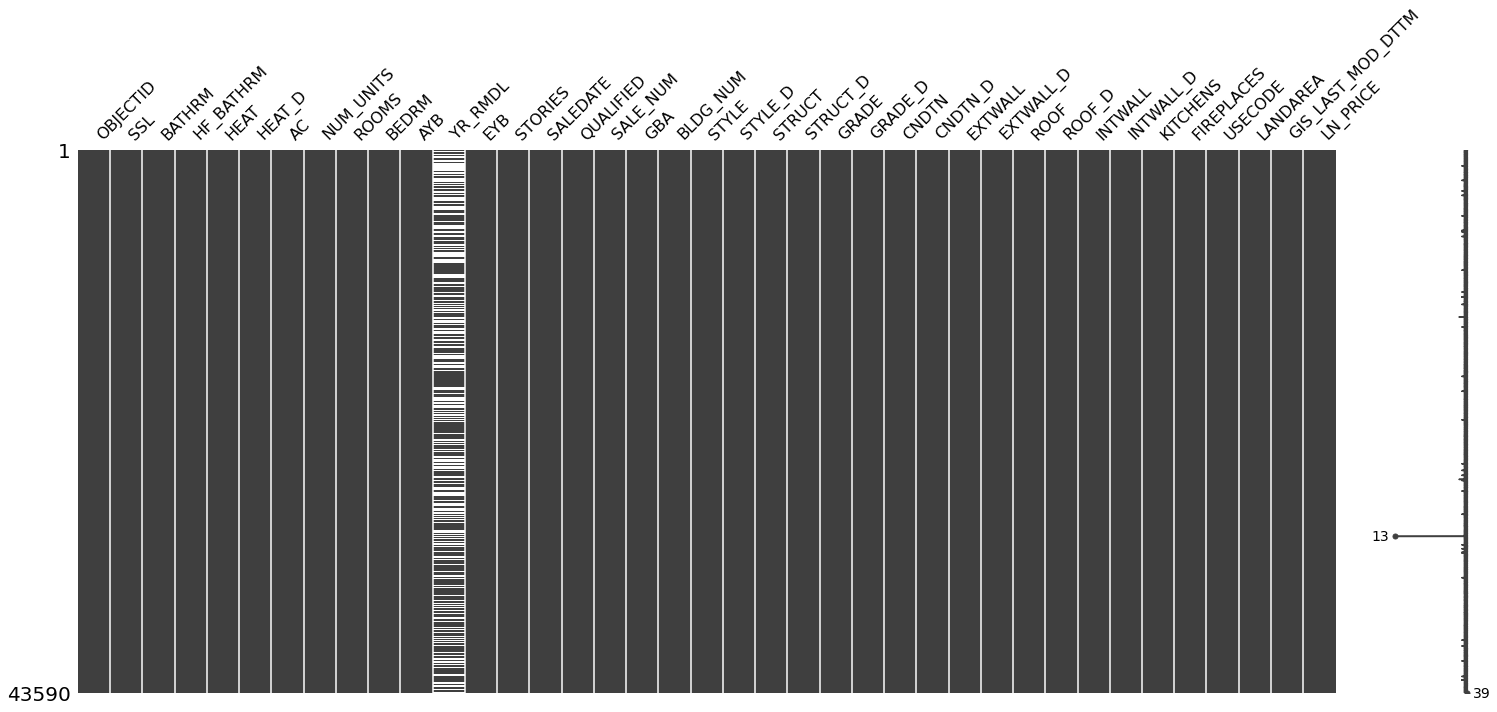

In [11]:
#Look at missingness in the data
miss.matrix(train)

In [14]:
#Clean data
#Drop all observations where the outcome is missing 
train = train.dropna()
test = test.dropna()

# Only houses that are sold.
train = train[train.LN_PRICE > 0]
test = test[test.LN_PRICE > 0]

In [17]:
#Split the databased on the predictors.
y_train = train.LN_PRICE
x_train = train[["HF_BATHRM","KITCHENS","ROOMS","BEDRM","BATHRM","LANDAREA"]]
y_test = test.LN_PRICE
x_test = test[["HF_BATHRM","KITCHENS","ROOMS","BEDRM","BATHRM","LANDAREA"]]

In [18]:
# Look at the training data
x_train.shape

(24996, 6)

In [22]:
#rescale the training data for now
scaler = pp.MinMaxScaler()
col_names = list(x_train)
train_X = scaler.fit_transform(x_train)

In [23]:
# Convert back into data frame
x_train = pd.DataFrame(x_train,columns=col_names)
x_train

,HF_BATHRM,KITCHENS,ROOMS,BEDRM,BATHRM,LANDAREA
0,1.0,1.0,9.0,4.0,3.0,2234
2,2.0,1.0,9.0,4.0,2.0,7866
4,0.0,1.0,11.0,4.0,2.0,2097
6,0.0,1.0,7.0,4.0,3.0,2399
7,1.0,2.0,7.0,3.0,3.0,1360
...,...,...,...,...,...,...
43585,0.0,1.0,5.0,2.0,1.0,560
43586,1.0,1.0,7.0,3.0,2.0,1483
43587,0.0,1.0,9.0,4.0,2.0,1393
43588,1.0,2.0,6.0,3.0,3.0,878


In [24]:
# Specify Kfold splits 
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)
use_metrics = ["neg_mean_squared_error"]

In [26]:
#Run the Models
#Tuning Hyper-parameters
mod = KNN() 
mod.get_params()
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [27]:
tune_knn.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_mean_squared_error')

In [28]:
tune_knn.best_params_

{'n_neighbors': 10}

In [29]:
tune_knn.best_score_

-0.5229655332448357

### Decision Tree 

In [30]:
#All the parameters for a decision tree
DTree().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [31]:
tune_dt = GridSearchCV(DTree(),{'max_depth':[i for i in range(1,10)]},
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)
tune_dt

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [33]:
tune_dt.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='neg_mean_squared_error')

In [34]:
tune_dt.best_params_

{'max_depth': 6}

In [35]:
tune_dt.best_score_

-0.4059835950888262

### Random Forest 

In [36]:
RF().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [37]:
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [1,2]} # Only have three total. 
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [38]:
# This model will take longer to run given all the tuning parameters we're exploring
tune_rf.fit(x_train,y_train) 

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3], 'max_features': [1, 2],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [39]:
tune_rf.best_params_

{'max_depth': 3, 'max_features': 2, 'n_estimators': 1000}

In [40]:
tune_rf.best_score_

-0.43430804470206413

In [42]:
# piece together all these steps as one seamless pipeline

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ["ROOMS","BATHRM","LANDAREA"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['ROOMS',
                                                                          'BATHRM',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=30)],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [1, 2, 3, 5]},
                         {'model': [BaggingR

In [43]:
search.best_score_ # Mean out-of-sample (CV) error

-0.4409803719002568

In [44]:
#Look at the best model
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

### Test Performance

In [45]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(x_test)

In [46]:
m.mean_squared_error(y_test,pred_y)

0.43397579017108545

In [47]:
m.r2_score(y_test,pred_y)

0.28387431205708724

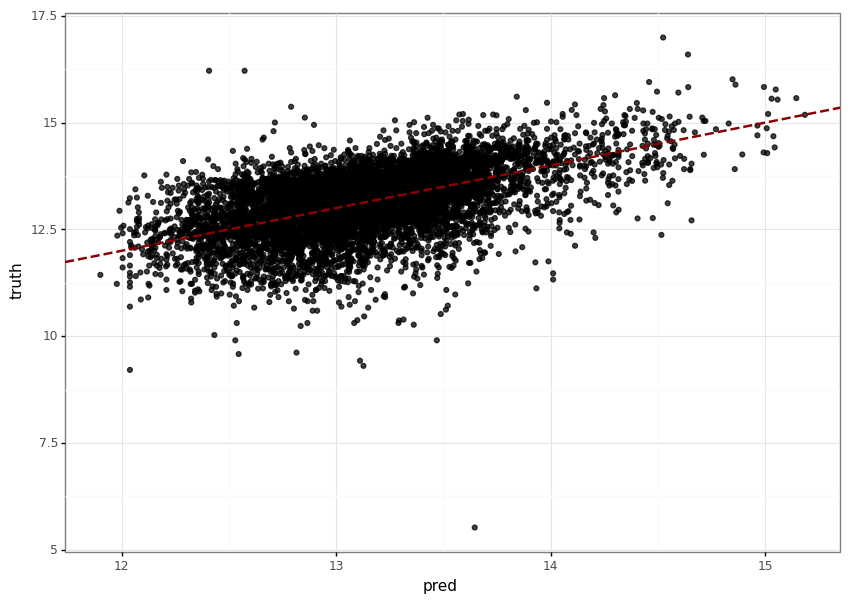

<ggplot: (8767005150202)>

In [48]:
#Visualize
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=y_test)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

### Result

The result indicates that the K-Nearest Neighbors model fits our test data best. However, the model produces an MSE of .434 and an R-squared value of .284, which is a pretty low R-sauqred value, indicating 28.4% of the variance for housing price can be explained our predictors. It indicates that there might be model which could predict our data better by restricting our predictors more accurately. 